In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import Colors
import JLD
import PyCall
import FileIO
using Statistics
using Plots

In [2]:
result_folder = "/Users/simon/Documents/DTU fag/Speciale/results/compare_snap"

"/Users/simon/Documents/DTU fag/Speciale/results/compare_snap"

## load the Snap results

In [3]:
rasterio = PyCall.pyimport("rasterio");

In [4]:
snap_tiff = rasterio.open("/Users/simon/Documents/DTU fag/Speciale/results/snap_result/vejle_subset_insar_snap_m20191005_s20191011.tif");
transform = snap_tiff.get_transform()
rows = collect(1:snap_tiff.height).-1;
columns = collect(1:snap_tiff.width).-1;
snap_lon = transform[1] .+ rows .* transform[2];
snap_lat = transform[4] .+ columns .* transform[6];

In [5]:
snap_coh = snap_tiff.read(1);
FileIO.save(joinpath(result_folder,"snap_coherence.jpg"),Colors.Gray.(snap_coh));

## Get own results

In [6]:
folder = "/Users/simon/Documents/DTU fag/Speciale/results/vejle_oktober_ABA"
own_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")
FileIO.save(joinpath(result_folder,"own_coherence.jpg"),Colors.Gray.(abs.(own_gamma)));

In [18]:
line_sample = JLD.load(joinpath(folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines =collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(folder,"21_lut.jld"),"data");

In [19]:
own_lat = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["latitude"],(length(lut["master_line"]),length(lut["master_sample"])))
, lines,samples)
own_lon = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["longitude"],(length(lut["master_line"]),length(lut["master_sample"])))
,lines,samples);

## Resample snap results

In [20]:
ndimage = PyCall.pyimport("scipy.ndimage");

In [21]:
idx1 = reshape((own_lat.-transform[4])./(transform[6]),:)
idx2 = reshape((own_lon.-transform[1])./transform[2],:);
index = [idx1,idx2];
snap_coh_re = ndimage.map_coordinates(snap_coh, index, order=1, mode="constant");
snap_coh_re= reshape(snap_coh_re,size(own_gamma));

In [22]:
FileIO.save(joinpath(result_folder,"snap_coherence_resampled.jpg"),Colors.Gray.(snap_coh_re));

## Compare

In [23]:
img = Colors.RGB{Float32}.(abs.(own_gamma),snap_coh_re,snap_coh_re);
FileIO.save(joinpath(result_folder,"ownSnapSnap_coherence.jpg"),img);

In [24]:
delta_cohe = abs.(abs.(own_gamma).- snap_coh_re)
delta_cohe[snap_coh_re .==0] .=0
FileIO.save(joinpath(result_folder,"diff_coherence.jpg"),Colors.Gray.(delta_cohe./2));


### Histogram

In [25]:
delta_cohe = (abs.(own_gamma).- snap_coh_re)
delta_cohe = reshape(delta_cohe,:)
delta_cohe = delta_cohe[reshape(snap_coh_re,:) .!=0];

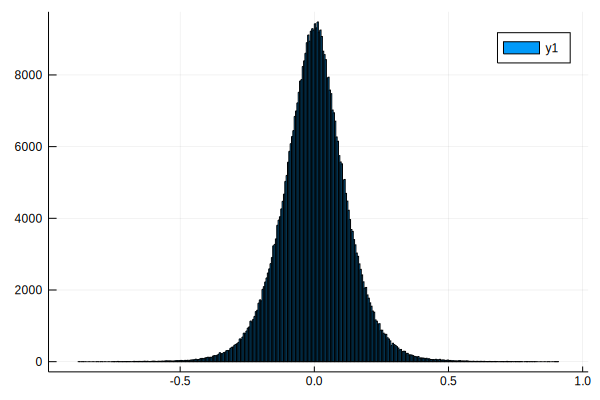

In [26]:
histogram(delta_cohe)

In [32]:
mean(delta_cohe)

0.0010496074375514592

##### Test with small ofset

In [33]:
offset = 1
delta_cohe = (abs.(own_gamma[:,1+offset:end]).- snap_coh_re[:,1:end-offset])
delta_cohe = reshape(delta_cohe,:)
delta_cohe = delta_cohe[reshape(snap_coh_re[:,1:end-offset],:) .!=0];

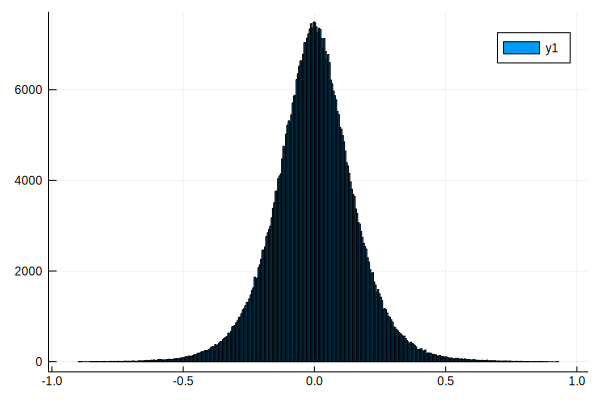

In [34]:
histogram(delta_cohe)

In [35]:
offset = 0
offset_2 = 1
delta_cohe = (abs.(own_gamma[1+offset:end,1+offset_2:end]).- snap_coh_re[1:end-offset,1:end-offset_2])
delta_cohe = reshape(delta_cohe,:)
delta_cohe = delta_cohe[reshape(snap_coh_re[1:end-offset,1:end-offset_2],:) .!=0];

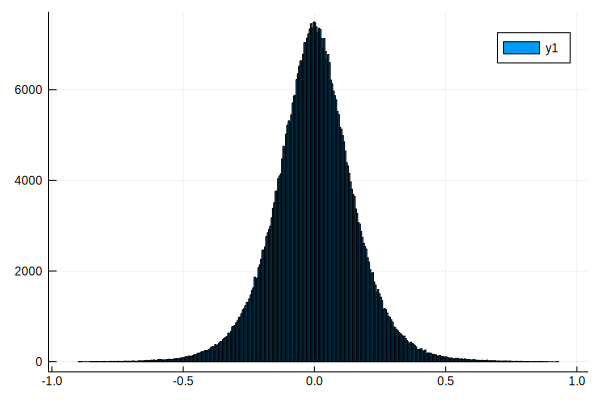

In [36]:
histogram(delta_cohe)

# Sigma 0

In [37]:
rasterio = PyCall.pyimport("rasterio");
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

-3

### Load Snap results

In [38]:
snap_tiff = rasterio.open("/Users/simon/Documents/DTU fag/Speciale/results/snap_result/subset_0_of_S1A_IW_SLC__1SDV_20200217_snap_result.tif");
transform = snap_tiff.get_transform()
rows = collect(1:snap_tiff.height).-1;
columns = collect(1:snap_tiff.width).-1;
snap_lon = transform[1] .+ rows .* transform[2];
snap_lat = transform[4] .+ columns .* transform[6];

In [39]:
bands = [snap_tiff.read(i) for i in 1:2];

In [40]:
img = Colors.Gray.(db_scale_img(bands[2].+ 10^(-5),min_vv,max_vv));
FileIO.save(joinpath(result_folder,"snap_intenens_VV.jpg"),img );
img = Colors.Gray.(db_scale_img(bands[1].+ 10^(-5),min_vh,max_vh));
FileIO.save(joinpath(result_folder,"snap_intenens_VH.jpg"),img );

## Get own results

In [41]:
folder = "/Users/simon/Documents/DTU fag/Speciale/results/vejle_2020/factory"
own_VV = JLD.load(joinpath(folder,"1VV_itens.jld"),"data")
own_VH = JLD.load(joinpath(folder,"1VH_itens.jld"),"data");

In [42]:
img = Colors.Gray.(db_scale_img(own_VV,min_vv,max_vv));
FileIO.save(joinpath(result_folder,"own_intenens_VV.jpg"),img );
img = Colors.Gray.(db_scale_img(own_VH,min_vh,max_vh));
FileIO.save(joinpath(result_folder,"own_intenens_VH.jpg"),img );

In [43]:
line_sample = JLD.load(joinpath(folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines = collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(folder,"21_lut.jld"),"data");

own_lat = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["latitude"],(length(lut["master_line"]),length(lut["master_sample"])))
, lines,samples)
own_lon = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["longitude"],(length(lut["master_line"]),length(lut["master_sample"])))
,lines,samples);

## Resample snap results

In [44]:
ndimage = PyCall.pyimport("scipy.ndimage");

In [45]:
idx1 = reshape((own_lat.-transform[4])./(transform[6]),:)
idx2 = reshape((own_lon.-transform[1])./transform[2],:);
index = [idx1,idx2];
bands_re = [ndimage.map_coordinates(elem, index, order=1, mode="constant") for elem in bands];
bands_re  = [reshape(elem,size(own_VV)) for elem in bands_re];

In [46]:
img = Colors.Gray.(db_scale_img(bands_re[2].+ 10^(-5),min_vv,max_vv));
FileIO.save(joinpath(result_folder,"snap_intenens_VV_resampled.jpg"),img );
img = Colors.Gray.(db_scale_img(bands_re[1].+ 10^(-5),min_vh,max_vh));
FileIO.save(joinpath(result_folder,"snap_intenens_VH_resampled.jpg"),img );

## Compare

In [47]:
snap = copy(bands_re[2])
snap[snap.==0] .= 10^(-5)
snap = db_scale_img(snap,min_vv,max_vv)
own = db_scale_img(own_VV,min_vv,max_vv)

img = Colors.RGB{Float32}.(own,snap,snap);
FileIO.save(joinpath(result_folder,"ownSnapSnap_intensity_VV.jpg"),img);

In [48]:
snap = copy(bands_re[1])
snap[snap.==0] .= 10^(-5)
snap = db_scale_img(snap,min_vh,max_vh)
own = db_scale_img(own_VH,min_vh,max_vh)

img = Colors.RGB{Float32}.(own,snap,snap);
FileIO.save(joinpath(result_folder,"ownSnapSnap_intensity_VH.jpg"),img);

### Histogram 

In [49]:
delta = (own_VV.- bands_re[2])
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];

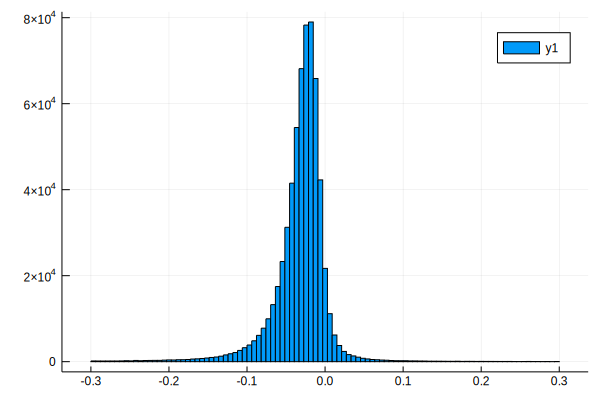

In [50]:
histogram(delta,bins=range(-0.3,stop =0.3, length = 100))

In [51]:
delta = (own_VH.- bands_re[1])
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];

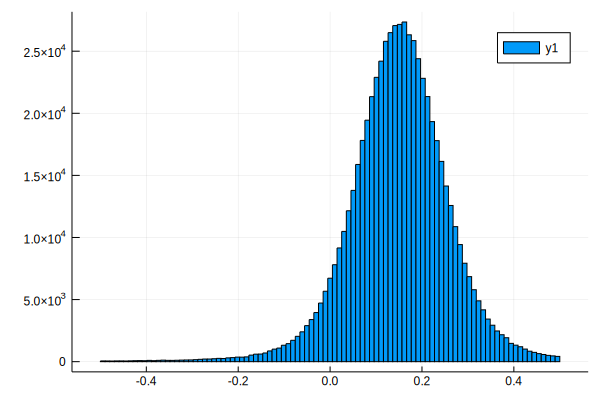

In [68]:
histogram(delta,bins=range(-0.5,stop =0.5, length = 100))

In [53]:
delta = (bands_re[2]./own_VV)
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];
delta[delta .<1 ] .= 1 ./delta[delta .<1 ];

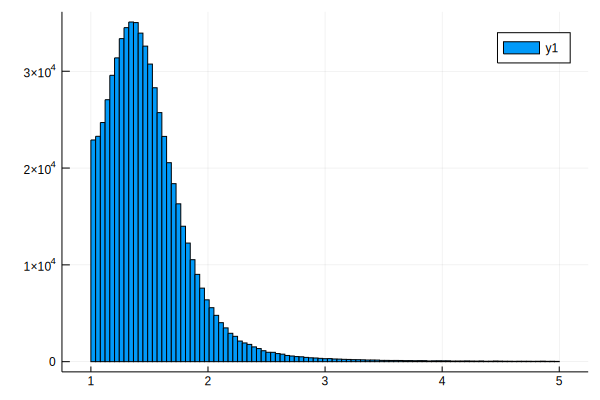

In [54]:
histogram(delta,bins=range(1,stop =5, length = 100))

In [81]:
offset = 0
offset_2 = 0
test = own_VV
delta = (bands_re[2][1:end-offset,1:end-offset_2]./own_VV[1+offset:end,1+offset_2:end])
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2][1:end-offset,1:end-offset_2],:) .!=0];
delta .= log10.(delta);

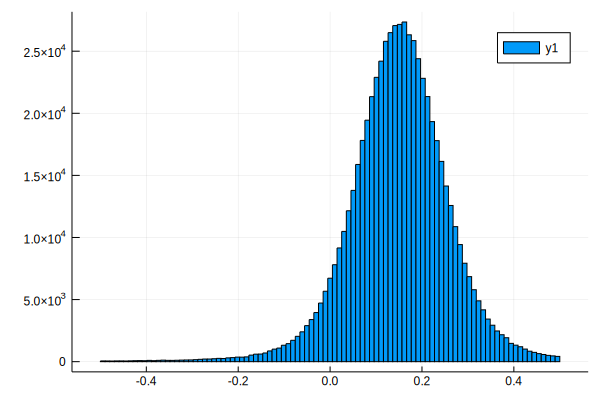

In [82]:
histogram(delta,bins=range(-0.5,stop =0.5, length = 100))

In [57]:
10^0.1

1.2589254117941673

In [73]:
offset = 0
offset_2 = 0

snap = copy(bands_re[2][1:end-offset,1:end-offset_2])
snap[snap.==0] .= 10^(-5)
snap = db_scale_img(snap,min_vv,max_vv)
own = db_scale_img(own_VV[1+offset:end,1+offset_2:end],min_vv,max_vv)

img = Colors.RGB{Float32}.(own,snap,snap);
FileIO.save(joinpath(result_folder,"ownSnapSnap_intensity_VV_offset.jpg"),img);

In [71]:
offset = 0

delta = (bands_re[2][1+offset:end,:]./own_VV[1:end-offset,:])
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2][1+offset:end,:],:) .!=0];
delta[delta .<1 ] .= 1 ./delta[delta .<1 ];

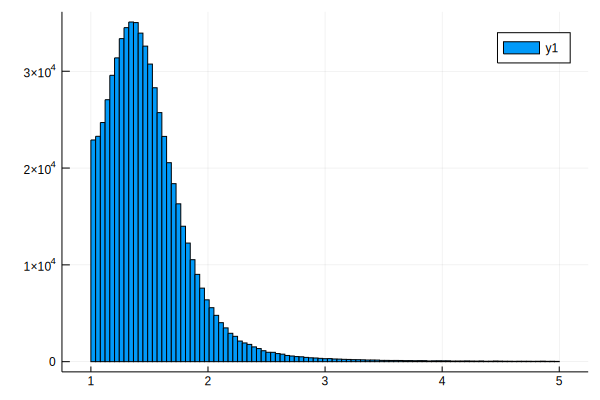

In [72]:
histogram(delta,bins=range(1,stop =5, length = 100))